# COVID-19 India Matplotlib Overview
> Tracking coronavirus total cases, deaths and new cases in India

- author: Hargun Oberoi
- image: images/covid-overview.png
- permalink: /covid-overview-linde-matplotlib/
- hide: false
- badges: false

In [1]:
#hide
import pandas as pd
import numpy as np
import requests
import datetime as dt
from jinja2 import Template
from IPython.display import HTML
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns

In [2]:
#hide
url = 'https://raw.githubusercontent.com/hargun3045/dashboards/master/abb_dict.json'
r = requests.get(url)
abb_dict = r.json()

In [3]:
#hide
#write a function that checks if all last index values are zero, and also selects the appropriate date columns
def get_dates(df):
    dt_cols = df.columns[~df.columns.isin(['stateABB','states'])]
    valid_i = -1
    for i in range(-1,-len(dt_cols),-1):
        if not df[dt_cols[i]].fillna(0).eq(0).all():
            valid_i = i
            break
    return valid_i, dt_cols

In [4]:
#hide
def get_frame(name):
#    pdb.set_trace()
    url = f'http://api.covid19india.org/states_daily_csv/{name}.csv'
    df = pd.read_csv(url)
    df.set_index('date',inplace = True)
    df = df.T
    df = df.iloc[:-1,:]
    df.fillna(0,inplace=True)
    df = df[df.columns].astype(int)
    df = df.rename_axis('stateABB').reset_index()
    df['states'] = df['stateABB'].map(abb_dict)
    df = df[[df.columns[-1]] + list(df.columns[:-1])]
    df =df.iloc[1:,:]
    df = df[df.states.notna()]
    df.sort_values(by = [df.columns[-1]], ascending = False, inplace = True)
    df.drop(['stateABB'],axis = 1)
    df = df.groupby('states').sum().cumsum(axis=1)
    df.reset_index(inplace = True)
    return df

In [5]:
#hide
dft_cases = get_frame('confirmed')
dft_deaths = get_frame('deceased')

In [6]:
#hide
valid_i, dt_cols = get_dates(dft_cases)
dt_today = dt_cols[valid_i]
dt_yday = dt_cols[valid_i -1]

In [7]:
#hide
dfc_cases = dft_cases.groupby('states')[dt_today].sum()
dfc_deaths = dft_deaths.groupby('states')[dt_today].sum()
dfp_cases = dft_cases.groupby('states')[dt_yday].sum()
dfp_deaths = dft_deaths.groupby('states')[dt_yday].sum()

In [8]:
#hide
# Build the cases table
df_table = (pd.DataFrame(dict(Cases = dfc_cases, Deaths = dfc_deaths, PCases = dfp_cases, PDeaths = dfp_deaths))
            .sort_values(by = ['Cases','Deaths'], ascending = [False, False])
            .reset_index())
for c in 'Cases, Deaths'.split(', '):
    df_table[f'{c} (+)'] = (df_table[c] - df_table[f'P{c}']).clip(0)
    #Clip ça veut dire, les chiffres negatif sont interdit
df_table['Fatality Rate'] = (100* df_table['Deaths']/ df_table['Cases']).round(2)

In [9]:
#hide
#Building the summary tab
metrics = [df_table.columns[index] for index in [1,2,5,6]]
s_mah = df_table[df_table.states == 'Maharashtra'][metrics].sum().add_prefix('MH ').astype(int)
s_del = df_table[df_table.states =='Delhi'][metrics].sum().add_prefix('DEL ').astype(int)
s_guj = df_table[df_table.states == 'Gujarat'][metrics].sum().add_prefix('GUJ ').astype(int)
summary = {'updated': pd.to_datetime(dt_today).date(), 'since': pd.to_datetime(dt_yday).date()}
summary = {**summary, **df_table[metrics].sum().astype(int), **s_mah, **s_del, **s_guj}

In [10]:
#hide
def myconverter(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, datetime.datetime):
            return obj.__str__()
        elif isinstance(obj, datetime.date):
            return obj.__str__()

In [11]:
#hide
#Data on new cases
dft_ct_new_cases = dft_cases.groupby('states')[dt_cols].sum().diff(axis=1).fillna(0).astype(int)
dft_ct_new_cases.sort_values(by = [dft_ct_new_cases.columns[-1]], ascending = False,inplace = True)

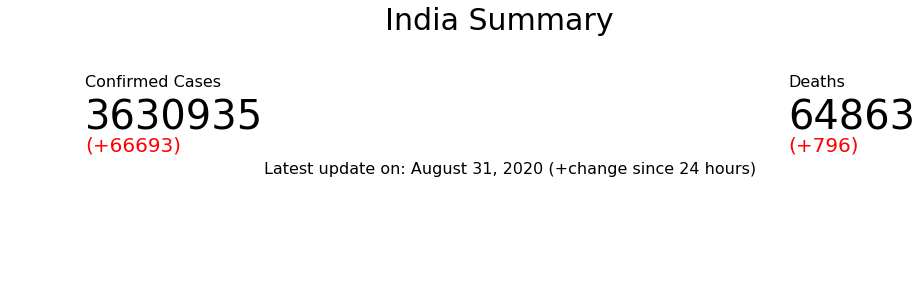

In [12]:
#hide
fig, ax = plt.subplots(facecolor='white',figsize = (14,4))

ax.axis([0, 10, 0, 10])

# This chunk is for overall
ax.text(0.5,1, f'India Summary', transform = fig.transFigure, fontsize = 30);
ax.text(0.38,0.5, f"Latest update on: {summary['updated'].strftime('%B %d, %Y')} (+change since 24 hours)", transform = fig.transFigure, fontsize = 16);

ax.text(0.1, 0.9,f'Confirmed Cases' , transform=ax.transAxes,fontsize = 16);
ax.text(1, 0.9,f'Deaths' , transform=ax.transAxes,fontsize = 16)

ax.text(0.1, 0.7,f"{summary['Cases']}" , transform=ax.transAxes,fontsize = 40);
ax.text(1, 0.7,f"{summary['Deaths']}" , transform=ax.transAxes,fontsize = 40)

ax.text(0.1, 0.6,f"(+{summary['Cases (+)']})" ,color='r', transform=ax.transAxes,fontsize = 20);
ax.text(1, 0.6,f"(+{summary['Deaths (+)']})" ,color ='r', transform=ax.transAxes,fontsize = 20)

## End of chunk
ax.set_axis_off()

In [13]:
#hide_input
overview = '''
<!-- #######  YAY,HTML!! #########-->
<h1 style="color: #5e9ca0; text-align: center;">India</h1>
<p style="text-align: center;">Last update: <strong>{update}</strong></p>
<p style="text-align: center;">Confirmed cases:</p>
<h1 style="text-align: center;">{cases} (<span style="color: #ff0000;">+{new}</span>)</h1>
<p style="text-align: center;">Confirmed deaths:</p>
<h1 style="text-align: center;">{deaths} (<span style="color: #ff0000;">+{dnew}</span>)</h1>
'''

update = summary['updated'].strftime('%B %d %Y')
cases = summary['Cases']
new = summary['Cases (+)']
deaths = summary['Deaths']
dnew = summary['Deaths (+)']

html = HTML(overview.format(update=update, cases=cases,new=new,deaths=deaths,dnew=dnew))

display(html)

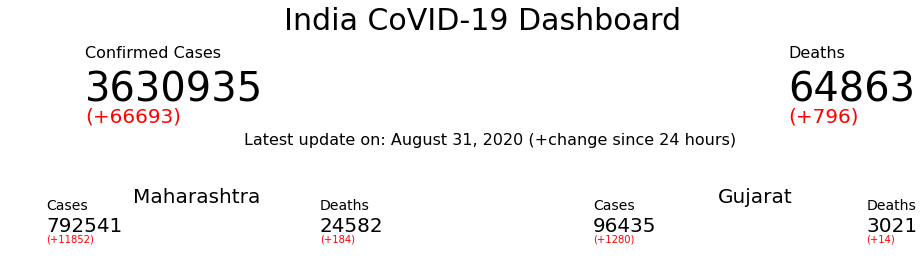

In [14]:
#hide
fig, ax = plt.subplots(facecolor='white',figsize = (14,4))

ax.axis([0, 10, 0, 10])

# This chunk is for overall
ax.text(0.4,0.9, f'India CoVID-19 Dashboard', transform = fig.transFigure, fontsize = 30);
ax.text(0.36,0.5, f"Latest update on: {summary['updated'].strftime('%B %d, %Y')} (+change since 24 hours)", transform = fig.transFigure, fontsize = 16);

ax.text(0.1, 0.9,f'Confirmed Cases' , transform=ax.transAxes,fontsize = 16);
ax.text(1, 0.9,f'Deaths' , transform=ax.transAxes,fontsize = 16)

ax.text(0.1, 0.7,f"{summary['Cases']}" , transform=ax.transAxes,fontsize = 40);
ax.text(1, 0.7,f"{summary['Deaths']}" , transform=ax.transAxes,fontsize = 40)

ax.text(0.1, 0.6,f"(+{summary['Cases (+)']})" ,color='r', transform=ax.transAxes,fontsize = 20);
ax.text(1, 0.6,f"(+{summary['Deaths (+)']})" ,color ='r', transform=ax.transAxes,fontsize = 20)

## End of chunk

# Attempting Maharashtra Chunk

ax.text(0.25,0.3, f'Maharashtra', transform = fig.transFigure, fontsize = 20);

ax.text(0.05, 0.2,f'Cases' , transform=ax.transAxes,fontsize = 14);
ax.text(0.4, 0.2,f'Deaths' , transform=ax.transAxes,fontsize = 14)

ax.text(0.05, 0.1,f"{summary['MH Cases']}" , transform=ax.transAxes,fontsize = 20);
ax.text(0.4, 0.1,f"{summary['MH Deaths']}" , transform=ax.transAxes,fontsize = 20)

ax.text(0.05, 0.05,f"(+{summary['MH Cases (+)']})" ,color='r', transform=ax.transAxes,fontsize = 10);
ax.text(0.4, 0.05,f"(+{summary['MH Deaths (+)']})" ,color ='r', transform=ax.transAxes,fontsize = 10)

## End Maharashtra Chunk

# Gujarat Chunk

ax.text(0.83,0.3, f'Gujarat', transform = fig.transFigure, fontsize = 20);

ax.text(0.75, 0.2,f'Cases' , transform=ax.transAxes,fontsize = 14);
ax.text(1.1, 0.2,f'Deaths' , transform=ax.transAxes,fontsize = 14)

ax.text(0.75, 0.1,f"{summary['GUJ Cases']}" , transform=ax.transAxes,fontsize = 20);
ax.text(1.1, 0.1,f"{summary['GUJ Deaths']}" , transform=ax.transAxes,fontsize = 20)

ax.text(0.75, 0.05,f"(+{summary['GUJ Cases (+)']})" ,color='r', transform=ax.transAxes,fontsize = 10);
ax.text(1.1, 0.05,f"(+{summary['GUJ Deaths (+)']})" ,color ='r', transform=ax.transAxes,fontsize = 10)

ax.set_axis_off()

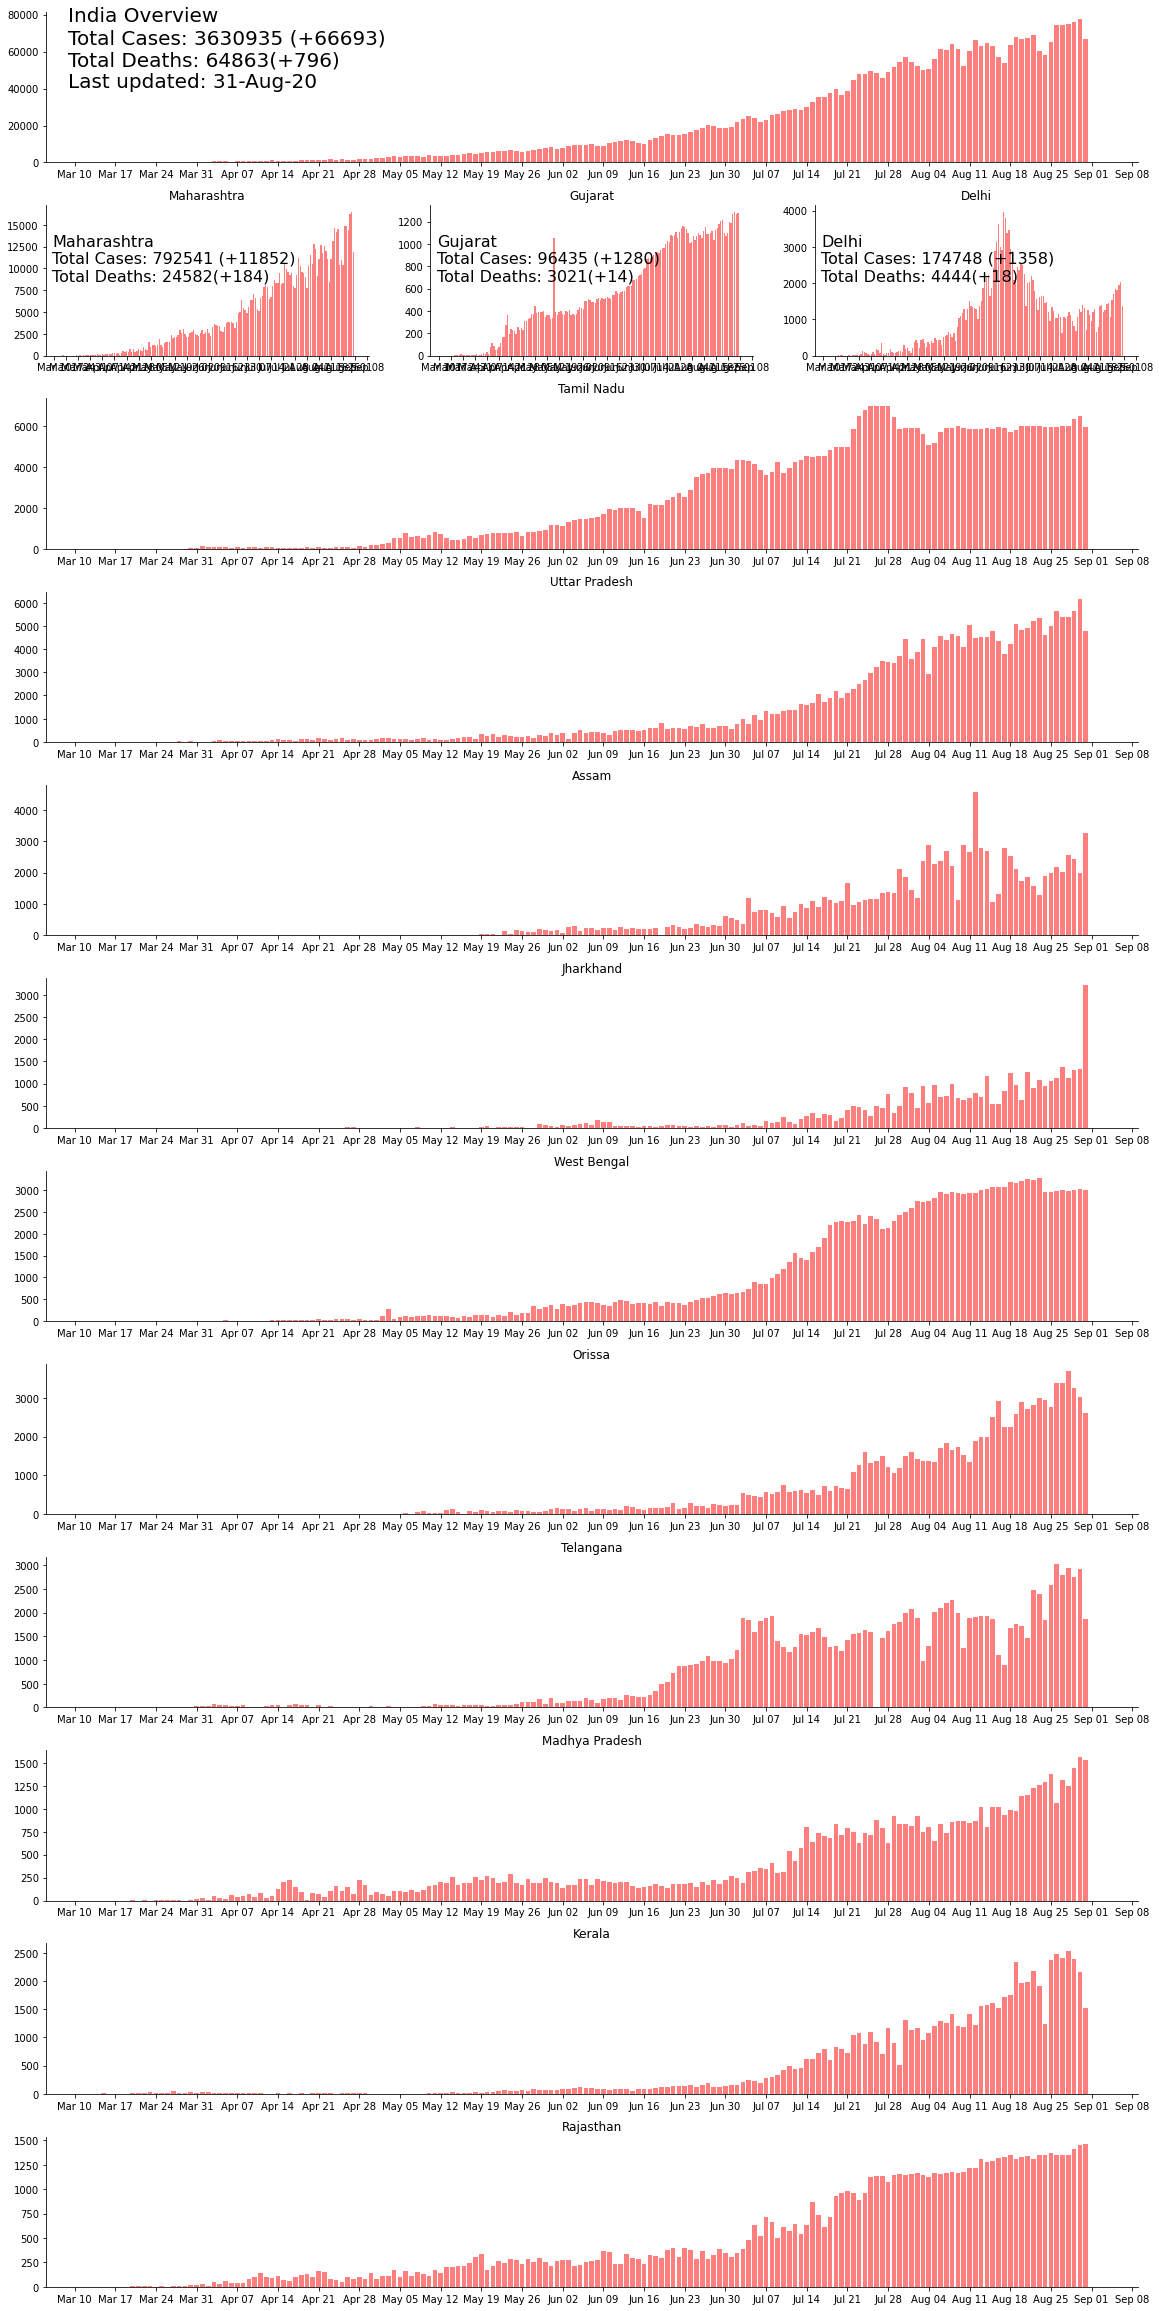

In [15]:
#hide_input
df = dft_ct_new_cases
df.loc['Total'] = df.sum()
n = 10
ax = []
fig = plt.figure(constrained_layout=True, figsize = (16,32))
gs = fig.add_gridspec(n+2, 3)
# gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0, :])
ef = df.loc['Total'].reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax1.bar(ef.date,ef.Total ,color = 'r',alpha=0.5)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
textstr = '\n'.join((
f"India Overview",
f"Total Cases: {summary['Cases']} (+{summary['Cases (+)']})",
f"Total Deaths: {summary['Deaths']}(+{summary['Deaths (+)']})",
f"Last updated: {dt_today}"
))
ax1.text(0.02, 0.50, textstr,transform = ax1.transAxes, fontsize = 20);


ax2 = fig.add_subplot(gs[1,0])
ef = df.loc['Maharashtra'].reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax2.bar(ef.date, ef.Maharashtra,color = 'r',alpha=0.5)
ax2.set_title('Maharashtra')
ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
textstr = '\n'.join((
f"Maharashtra",
f"Total Cases: {summary['MH Cases']} (+{summary['MH Cases (+)']})",
f"Total Deaths: {summary['MH Deaths']}(+{summary['MH Deaths (+)']})"
))
ax2.text(0.02, 0.50, textstr,transform = ax2.transAxes, fontsize = 16);


ax3 = fig.add_subplot(gs[1,1])
ef = df.loc['Gujarat'].reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax3.bar(ef.date, ef.Gujarat,color = 'r',alpha=0.5)
ax3.set_title('Gujarat')
ax3.xaxis.set_major_locator(mdates.WeekdayLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
textstr = '\n'.join((
f"Gujarat",
f"Total Cases: {summary['GUJ Cases']} (+{summary['GUJ Cases (+)']})",
f"Total Deaths: {summary['GUJ Deaths']}(+{summary['GUJ Deaths (+)']})"
))
ax3.text(0.02, 0.50, textstr,transform = ax3.transAxes, fontsize = 16);

ax4 = fig.add_subplot(gs[1,2])
ef = df.loc['Delhi'].reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax4.bar(ef.date, ef.Delhi,color = 'r',alpha=0.5)
ax4.set_title('Delhi')
ax4.xaxis.set_major_locator(mdates.WeekdayLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
textstr = '\n'.join((
f"Delhi",
f"Total Cases: {summary['DEL Cases']} (+{summary['DEL Cases (+)']})",
f"Total Deaths: {summary['DEL Deaths']}(+{summary['DEL Deaths (+)']})"
))
ax4.text(0.02, 0.50, textstr,transform = ax4.transAxes, fontsize = 16);

for i in range(n):
    
    ax.append(fig.add_subplot(gs[i+2,:]))
    ef = df.iloc[i+3].reset_index()
    ef['date'] = ef['date'].astype('datetime64[ns]')
    ax[i].bar(ef.date,ef.iloc[:,-1],color = 'r',alpha=0.5)
    ax[i].set_title(f'{ef.columns.values[-1]}')
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    

sns.despine()

In [16]:
#hide_input
print(df_table.head(20).to_string(index=False))

            states   Cases  Deaths  PCases  PDeaths  Cases (+)  Deaths (+)  Fatality Rate
       Maharashtra  792541   24582  780689    24398      11852         184           3.10
    Andhra Pradesh  434771    3969  424767     3884      10004          85           0.91
        Tamil Nadu  428041    7322  422085     7231       5956          91           1.71
         Karnataka  342423    5709  335928     5596       6495         113           1.67
     Uttar Pradesh  230414    3486  225632     3423       4782          63           1.51
             Delhi  174748    4444  173390     4426       1358          18           2.54
       West Bengal  162778    3228  159785     3176       2993          52           1.98
             Bihar  136337     694  135013      688       1324           6           0.51
         Telangana  124453     827  122580      818       1873           9           0.66
             Assam  108939     310  105673      300       3266          10           0.28
          

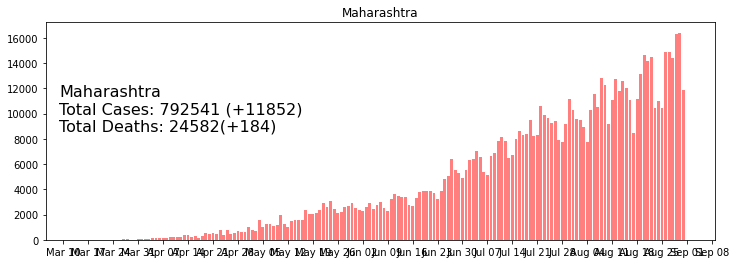

In [17]:
#hide
fig, ax2 = plt.subplots(figsize = (12,4))
ef = df.loc['Maharashtra'].reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax2.bar(ef.date, ef.Maharashtra, color = 'r', alpha = 0.5)
ax2.set_title('Maharashtra')
#set ticks every week
ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
textstr = '\n'.join((
f"Maharashtra",
f"Total Cases: {summary['MH Cases']} (+{summary['MH Cases (+)']})",
f"Total Deaths: {summary['MH Deaths']}(+{summary['MH Deaths (+)']})"
))
ax2.text(0.02, 0.50, textstr,transform = ax2.transAxes, fontsize = 16);